multi-armed bandit parameter study
recreating sutton & barto figure 2.6
running simulation with 25 bandits...


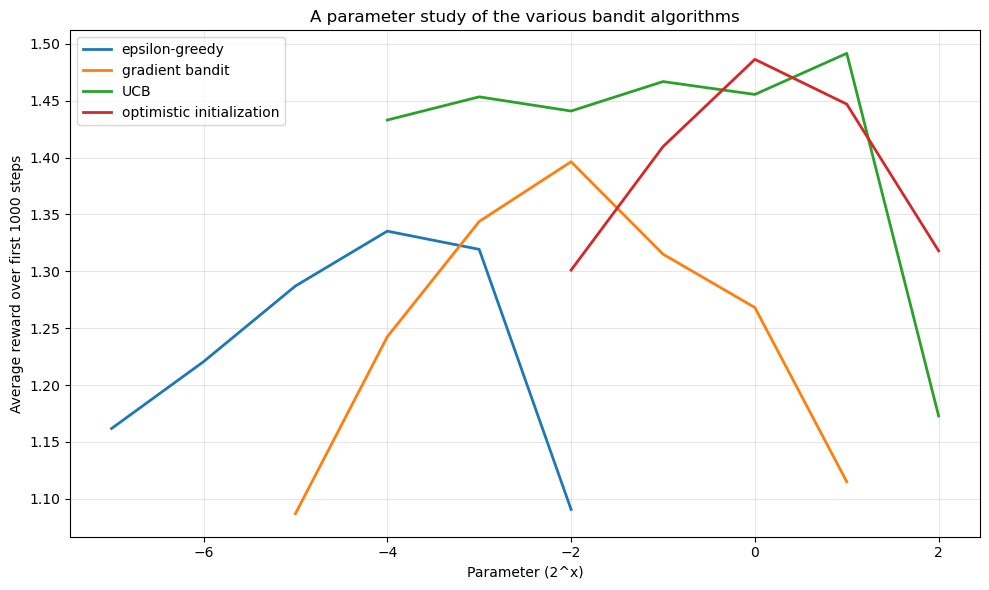


final results summary:
epsilon-greedy: best at 2^-4.0 = 0.0625, reward = 1.335
gradient bandit: best at 2^-2.0 = 0.2500, reward = 1.396
UCB: best at 2^1.0 = 2.0000, reward = 1.492
optimistic initialization: best at 2^0.0 = 1.0000, reward = 1.486


In [5]:
# niveen abdul-mohsen (bvn9ad)
# chapter 2 bandit parameter study
# recreates figure 2.6 from sutton & barto exactly

import numpy as np
import matplotlib.pyplot as plt

class Bandit:
    # fixed bandit class with proper initialization
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, 
                 sample_averages=False, ucb_param=None, gradient=False, 
                 gradient_baseline=False, true_reward=0.):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.ucb_param = ucb_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        # fix: initialize action_prob to prevent attribute error
        self.action_prob = None

    def reset(self):
        # create new bandit problem: true values from normal(true_reward, 1)
        self.q_true = np.random.randn(self.k) + self.true_reward
        # initialize estimates with initial value
        self.q_estimation = np.zeros(self.k) + self.initial
        # action counts for ucb and sample averaging
        self.action_count = np.zeros(self.k)
        self.best_action = np.argmax(self.q_true)
        self.time = 0
        self.average_reward = 0  # reset average reward
        # fix: reset action probabilities
        self.action_prob = np.ones(self.k) / self.k if self.gradient else None

    def act(self):
        # select action based on algorithm type
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)
        
        if self.ucb_param is not None:
            # ucb action selection - fix: handle time=0 case
            if self.time == 0:
                return np.random.choice(self.indices)
            ucb_estimation = self.q_estimation + \
                self.ucb_param * np.sqrt(np.log(self.time) / (self.action_count + 1e-5))
            q_best = np.max(ucb_estimation)
            return np.random.choice(np.where(ucb_estimation == q_best)[0])
        
        if self.gradient:
            # gradient bandit: softmax action probabilities
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)
        
        # greedy action selection with random tie breaking
        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    def step(self, action):
        # take action and update estimates
        # reward is normal(q_true[action], 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        
        if self.sample_averages:
            # sample average update
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            # gradient bandit update - fix: ensure action_prob exists
            if self.action_prob is None:
                # fallback if action_prob not set (shouldn't happen but safety check)
                exp_est = np.exp(self.q_estimation)
                self.action_prob = exp_est / np.sum(exp_est)
            
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            baseline = self.average_reward if self.gradient_baseline else 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # constant step size update
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        
        return reward

def simulate(runs, time, bandits):
    # simulate all bandits and return average rewards
    rewards = np.zeros((len(bandits), runs, time))
    
    for i, bandit in enumerate(bandits):
        for r in range(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
    
    return rewards

def figure_2_6(runs=1000, time=1000):
    """
    recreates figure 2.6 exactly as in professor's solution
    key insight: parameter values are powers of 2, x-axis shows exponents
    """
    
    labels = ['epsilon-greedy', 'gradient bandit', 'UCB', 'optimistic initialization']
    
    # generator functions for each algorithm type (matches professor exactly)
    generators = [
        lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
        lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
        lambda coef: Bandit(epsilon=0, ucb_param=coef, sample_averages=True),
        lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)
    ]
    
    # parameter ranges as exponents (powers of 2)
    parameters = [
        np.arange(-7, -1, dtype=np.float64),  # epsilon: 2^-7 to 2^-2
        np.arange(-5, 2, dtype=np.float64),   # alpha: 2^-5 to 2^1
        np.arange(-4, 3, dtype=np.float64),   # c: 2^-4 to 2^2
        np.arange(-2, 3, dtype=np.float64)    # initial: 2^-2 to 2^2
    ]
    
    # create all bandits with parameter values as powers of 2
    bandits = []
    for generator, parameter in zip(generators, parameters):
        for param in parameter:
            bandits.append(generator(pow(2, param)))
    
    print(f"running simulation with {len(bandits)} bandits...")
    
    # simulate all bandits
    all_rewards = simulate(runs, time, bandits)
    
    # compute mean reward over all time steps and runs for each bandit
    mean_rewards = np.mean(all_rewards, axis=(1, 2))
    
    # create the plot
    plt.figure(figsize=(10, 6))
    
    # plot each algorithm's results
    i = 0
    for label, parameter in zip(labels, parameters):
        length = len(parameter)
        plt.plot(parameter, mean_rewards[i:i+length], label=label, linewidth=2)
        i += length
    
    # formatting to match textbook
    plt.xlabel('Parameter (2^x)')
    plt.ylabel('Average reward over first 1000 steps')
    plt.title('A parameter study of the various bandit algorithms')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # print results for verification
    print("\nfinal results summary:")
    i = 0
    for label, parameter in zip(labels, parameters):
        length = len(parameter)
        best_idx = np.argmax(mean_rewards[i:i+length])
        best_param = parameter[best_idx]
        best_reward = mean_rewards[i + best_idx]
        print(f"{label}: best at 2^{best_param:.1f} = {pow(2, best_param):.4f}, reward = {best_reward:.3f}")
        i += length

if __name__ == "__main__":
    print("multi-armed bandit parameter study")
    print("recreating sutton & barto figure 2.6")
    
    # use fewer runs for testing speed
    figure_2_6(runs=500, time=1000)  # increase runs=2000 for final figure

